# Explore and clean data

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import statistics
import scipy.stats as st
from statsmodels.graphics.gofplots import qqplot
%matplotlib inline

In [70]:
gltbc = pd.read_csv("./data/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCountry.csv")
gltbc.head(5)

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [72]:
gltbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577462 entries, 0 to 577461
Data columns (total 4 columns):
dt                               577462 non-null object
AverageTemperature               544811 non-null float64
AverageTemperatureUncertainty    545550 non-null float64
Country                          577462 non-null object
dtypes: float64(2), object(2)
memory usage: 17.6+ MB


In [77]:
#Interpolating NaN - Values in AverageTemperature row
#Dropping unneccesary columns
gltbc_clean = gltbc.copy()
gltbc_clean.drop(['AverageTemperatureUncertainty'], inplace = True, axis = 1)
gltbc_clean['AverageTemperature'].interpolate(method = 'linear', inplace = True)

In [6]:
#Cast 'dt' colum to DateTime object
gltbc_clean['dt'] = gltbc_clean['dt'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

In [7]:
#Select Germany subset
gltbc_ger = gltbc_clean[gltbc['Country'] == 'Germany'].copy()

In [40]:
#Add column with saisons and years
def season(date):
    if date.month < 3 or date.month == 12:
        return "Winter"
    
    elif date.month > 2 and date.month < 6:
        return "Spring"
    
    elif date.month > 5 and date.month < 9:
        return "Summer"
    
    else:
        return 'Autumn'
    
    
gltbc_ger['Season'] = gltbc_ger['dt'].apply(season)
gltbc_ger['Year'] = gltbc_ger['dt'].apply(lambda x: x.year)

In [44]:
#Drop data before 1850 and after 2012 as too many filled up NaN-values created anomalies
gltbc_ger = gltbc_ger[(gltbc_ger['Year'] > 1849) & (gltbc_ger['Year'] < 2013)].copy()

# Descriptive Statistics

Highest temperature, lowest, range, mean, median, mad and alpha trimmed mean, variance, standard distribution and skewness

In [58]:
#Calculate the max, min, mean and median etc.
min_temp = gltbc_ger['AverageTemperature'].min()
max_temp = gltbc_ger['AverageTemperature'].max()
range_temp = max_temp - min_temp
mean_temp = gltbc_ger['AverageTemperature'].mean()
median_temp = gltbc_ger['AverageTemperature'].median()
mad_temp = gltbc_ger['AverageTemperature'].mad()
trim_mean_temp = st.trim_mean(gltbc_ger['AverageTemperature'], 0.1)
var_temp = gltbc_ger['AverageTemperature'].var()
std_temp = gltbc_ger['AverageTemperature'].std()
skew_temp = st.skew(gltbc_ger['AverageTemperature'])


#Create DataFrame with values
data = {'Temperature in °C':map(lambda x: round(x, 2), [min_temp, max_temp, range_temp, mean_temp, median_temp, mad_temp, trim_mean_temp, var_temp, std_temp, skew_temp])}
stats = pd.DataFrame(data, index = ['min_temp max_temp range_temp mean_temp median_temp mad_temp trim_mean_temp var_temp std_temp skew_temp'.split(" ")])
stats

,Temperature in °C
min_temp,-9.30
max_temp,22.34
range_temp,31.64
mean_temp,8.27
median_temp,8.14
mad_temp,5.99
trim_mean_temp,8.40
var_temp,46.40
std_temp,6.81
skew_temp,-0.09


## Explore Distribution of the data

Distribution function of the average temperature by month

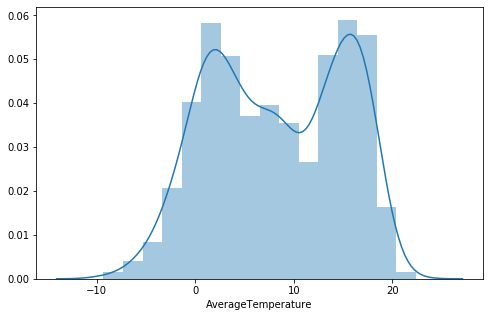

In [82]:
plt.figure(figsize=(8,5))
sns.distplot(gltbc_ger['AverageTemperature'])

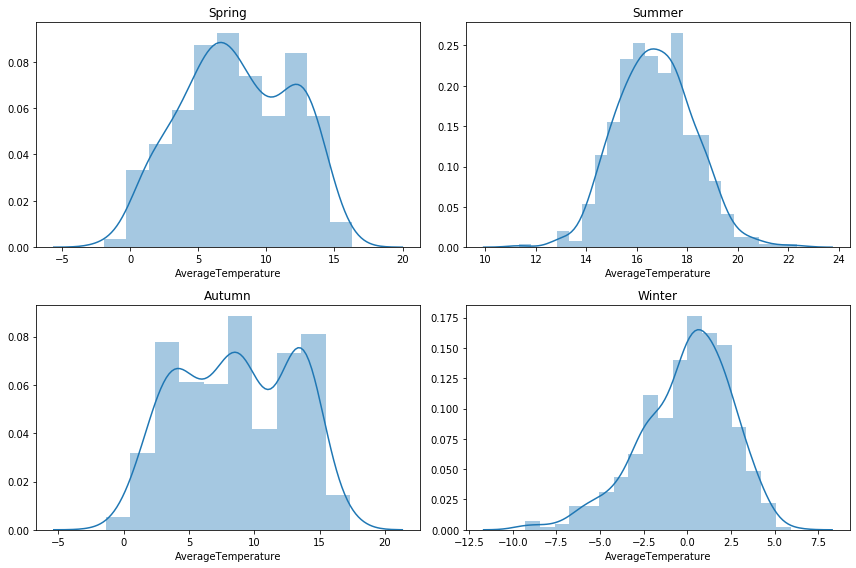

In [55]:
#Distribution function of the average temperature classified by seasons
fig, axs = plt.subplots(ncols=2, nrows=2, figsize = (12, 8))
sns.distplot(gltbc_ger[gltbc_ger['Season'] == 'Spring']['AverageTemperature'], ax=axs[0][0]).set_title('Spring')
sns.distplot(gltbc_ger[gltbc_ger['Season'] == 'Summer']['AverageTemperature'], ax=axs[0][1]).set_title('Summer')
sns.distplot(gltbc_ger[gltbc_ger['Season'] == 'Autumn']['AverageTemperature'], ax=axs[1][0]).set_title('Autumn')
sns.distplot(gltbc_ger[gltbc_ger['Season'] == 'Winter']['AverageTemperature'], ax=axs[1][1]).set_title('Winter')
plt.tight_layout()

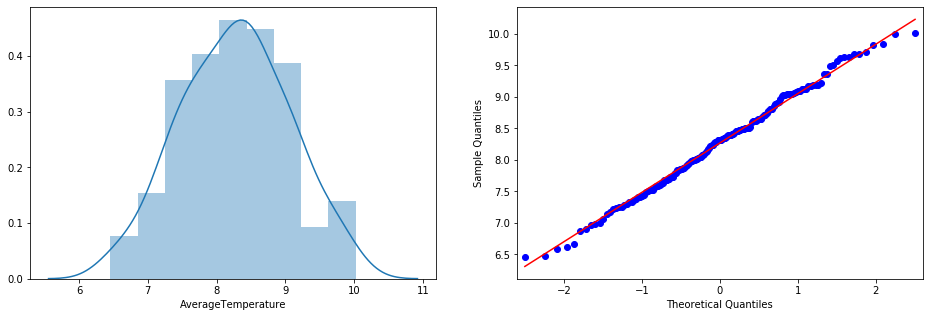

In [130]:
#Group the data by year to see if the distribution changes
gltbc_ger_byyear = gltbc_ger.groupby(['Year']).mean()

#Visual test for Gaussian distribution
fig, (axs1, axs2) = plt.subplots(1, 2, figsize = (16, 5))
sns.distplot(gltbc_ger_byyear['AverageTemperature'], ax = axs1)
qqplot(gltbc_ger_byyear['AverageTemperature'], line = 's', ax = axs2);

Judging by visual clues the data seems to be drawn from a Gaussian distribution
Null hypothesis: The data is normaly distributed

## Shapiro-Wilk Test

In [138]:
#Applying the Shapiro-Wilk test
stat, p = st.shapiro(gltbc_ger_byyear['AverageTemperature'])
print('Statistics = {}, p = {}'.format(stat, p))

#Interprete result
#p <= alpha: reject H0, not normal.
#p > alpha: fail to reject H0, normal.
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics = 0.9918380379676819, p = 0.48203927278518677
Sample looks Gaussian (fail to reject H0)


## Visualization of Data

Text(0.5, 1.0, 'Germany average Temperature 1850 - 2012')

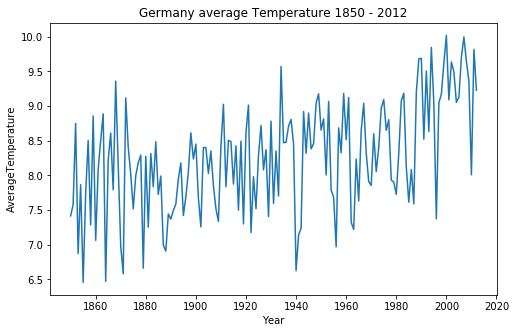

In [84]:
#Temperature over time
fig, axes = plt.subplots(figsize=(8,5))
axes.plot(gltbc_ger_byyear['AverageTemperature'])
axes.set_xlabel('Year')
axes.set_ylabel('AverageTemperature')
axes.set_title('Germany average Temperature 1850 - 2012')

Text(0.5, 1, 'Germany average Temperature 1850 - 2012')

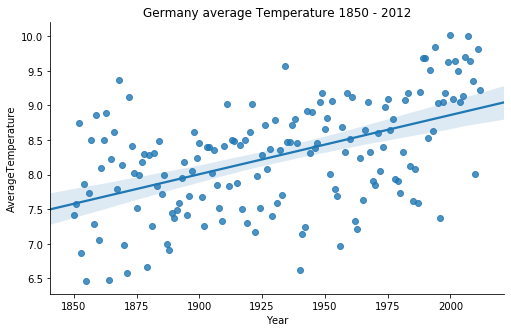

In [141]:
#Using lmplot to show linear regression
gltbc_ger_byyear.reset_index(level=0, inplace = True)
sns.lmplot(x = 'Year', y = 'AverageTemperature', data = gltbc_ger_byyear, height=4.5, aspect=1.6)
ax = plt.gca()
ax.set_title("Germany average Temperature 1850 - 2012")

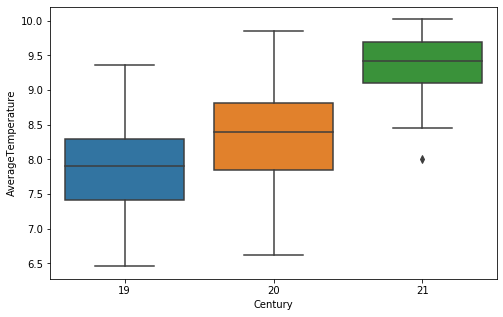

In [103]:
#Creating century column to visualize change over hundred years
def century(year):
    if year < 1800:
        return 18
    
    elif year < 1900 and year > 1800:
        return 19
    
    elif year < 2000 and year > 1900:
        return 20
    
    else:
        return 21
    
gltbc_ger_byyear['Century'] = gltbc_ger_byyear['Year'].apply(century)

#Creating one boxplot per century
plt.figure(figsize=(8,5))    
sns.boxplot(x = 'Century', y = 'AverageTemperature', data = gltbc_ger_byyear)